# Project 2: Diabetes Readmission Prediction

Data Set Information:
Source : https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1)	It is an inpatient encounter (a hospital admission).
(2)	It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3)	The length of stay was at least 1 day and at most 14 days.
(4)	Laboratory tests were performed during the encounter.
(5)	Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

Objective:
In this project, we will build a model predicting readmission for patients with diabetes. 
The steps we have gone through are:
1) Data exploration and Data cleaning
2) Building Training/Validation/Test samples
3) Model selection
4) Model evaluation

# Loading the required libraries required for data analysis

In [130]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy.stats import norm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from matplotlib.legend_handler import HandlerLine2D

In [131]:

# Major libraries
import scipy
import bottleneck # for speeding up pandas operations
import numexpr # ditto
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Mining / EDA / dimensionality reduction
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale
from scipy.spatial.distance import euclidean

# Supervised learning
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Unsupervised learning
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.colors import ListedColormap

# Data Loading
Two CSV Files are given.
1) Diabetic Data [1,01,766 rows] and
2) Ids_Mapping [Supplementary information to look up and hot encoding on certain variables in the dataset]

In [132]:
#Read the primary csv file
dia_df = {} # Manage multiple datasets by keeping them all in a dictionary
dia_df= pd.read_csv('E:\\Term 2\\Practicum\\dataset_diabetes\\diabetic_data.csv')
# To allow comparison between datasets before and after modification
dia_df1=dia_df.copy()
#Reading the secondary csv file
ids_mapping = pd.read_csv('E:\\Term 2\\Practicum\\dataset_diabetes\\IDs_mapping.csv') 

# Data Exploration and Cleaning

In [133]:
dia_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [134]:
#A first look at how the dataset looks like :
dia_df1.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Text(0,0.5,'Count')

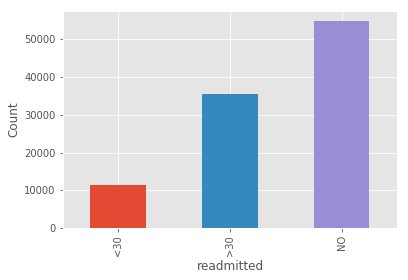

In [135]:
# the response variable 'readmitted' in the original dataset contains three categories.
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)
dia_df1.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

In [136]:
dia_df1['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [137]:
# Looking at the duplicated rows

# The dataset has information the hospital records when a patient gets admitted in the hospital.[Through the encounter id] 
# It is very well possible that a patient [patient_nbr] can have multiple entires.
# Dug deep into below 2 :
# a) Count of patients who were readmitted [< 30 or >30] : This accounted to ~30% of the total observations.
# b) Duplicated observation in the dataset : Added a new feature : 'No_Of_Encounters' specifying the no of admissions

num_hospital_admissions = len(dia_df1['encounter_id'].unique())
print('There are a total of {} hospital admissions recorded in the dataset.'.format(
    num_hospital_admissions))

dups_observations = dia_df1 .duplicated().sum()
print('There are a total of {} duplicated observations in the dataset.'.format(
    dups_observations))

number_patients = len(dia_df1['patient_nbr'].unique())
print('There are a total of {} patients admitted in the hospital'.format(number_patients))

readmit_patients = dia_df1['patient_nbr'].duplicated().sum()
print('There are {} observations coming from patients readmitted atleast once.'.format(
    readmit_patients))

dia_df1['No_of_Encounters'] = dia_df1 .groupby(
    'patient_nbr')['encounter_id'].transform("count")

There are a total of 101766 hospital admissions recorded in the dataset.
There are a total of 0 duplicated observations in the dataset.
There are a total of 71518 patients admitted in the hospital
There are 30248 observations coming from patients readmitted atleast once.


Before exploring more new features, dropped observations that don't add any value to the data analysis. 
Patients who expired or transferred to hospice are unlikely to get readmitted
We then obtained the 'discharge_disposition_id' for each of them & dropped these rows.

In [138]:
dia_df1 = dia_df1 [~dia_df1['discharge_disposition_id'].isin([11, 13, 14 ,19, 20, 21])]
# Reset the index
dia_df1.reset_index(inplace=True)

In [139]:
# Summarizing the data for categorical and numeric variables & to explore them separately

def subset_dia_df(dataframe, dtype_):
    """
    Pass an object [dtype] as 2nd argument : if the dataframe with categorical features is needed.
    Pass a number  [dtype] as 2nd argument : if the dataframe with numerical features is needed.
    """
    if isinstance(dataframe, pd.DataFrame):
        return dataframe.select_dtypes(include=dtype_)
    
cat_features_df = subset_dia_df(dia_df1, object)

#Exploring the categorical variables here to find the ? in the data and missing values

categorical_cols = cat_features_df.columns.tolist()

for col in categorical_cols:
    questionmark_character_count = cat_features_df[col][cat_features_df[col] == '?'].count()
    percent_questionmark_characters = round(100 * questionmark_character_count/cat_features_df.shape[0], 2)
    print(col, (questionmark_character_count, percent_questionmark_characters))
        
#There are no missing [blank] values in the dataframe but it has many '?' in it. 
#We summarized the '?' values in the dataframe as seen below for all the categorical variables

race (2234, 2.25)
gender (0, 0.0)
age (0, 0.0)
weight (96218, 96.85)
payer_code (39398, 39.66)
medical_specialty (48616, 48.94)
diag_1 (20, 0.02)
diag_2 (356, 0.36)
diag_3 (1419, 1.43)
max_glu_serum (0, 0.0)
A1Cresult (0, 0.0)
metformin (0, 0.0)
repaglinide (0, 0.0)
nateglinide (0, 0.0)
chlorpropamide (0, 0.0)
glimepiride (0, 0.0)
acetohexamide (0, 0.0)
glipizide (0, 0.0)
glyburide (0, 0.0)
tolbutamide (0, 0.0)
pioglitazone (0, 0.0)
rosiglitazone (0, 0.0)
acarbose (0, 0.0)
miglitol (0, 0.0)
troglitazone (0, 0.0)
tolazamide (0, 0.0)
examide (0, 0.0)
citoglipton (0, 0.0)
insulin (0, 0.0)
glyburide-metformin (0, 0.0)
glipizide-metformin (0, 0.0)
glimepiride-pioglitazone (0, 0.0)
metformin-rosiglitazone (0, 0.0)
metformin-pioglitazone (0, 0.0)
change (0, 0.0)
diabetesMed (0, 0.0)
readmitted (0, 0.0)


# Observational Insights :

# We dropped 'weight', 'payer_code' & 'medical_specialty' columns having > 1/3rd of the data with ?'s'

# About ~ 3% of observations in the 'race' column have no information. We changed it to 'Unknown'

# diag_1, diag_2, diag_3 are diagnostic columns. 

# We dropped any observations where values are missing in all three & replaced the remaining with 'Unknown'

# Age column is an object datatype because we were provided with information as 10 year bins.

In [140]:
#Summarize the missing data [in percentage] in the above dataframe
dia_df1= dia_df1.replace('?', np.NaN) 
#na_percentage = dia_df['Copy'] .isnull().sum()/len(dia_df['Copy'] )*100
#na_percentage
#We observe weight has 97% missing values followed by 40% for payer_code and 49% for medical_facility. 
#We go ahead and drop these columns in the futher cells

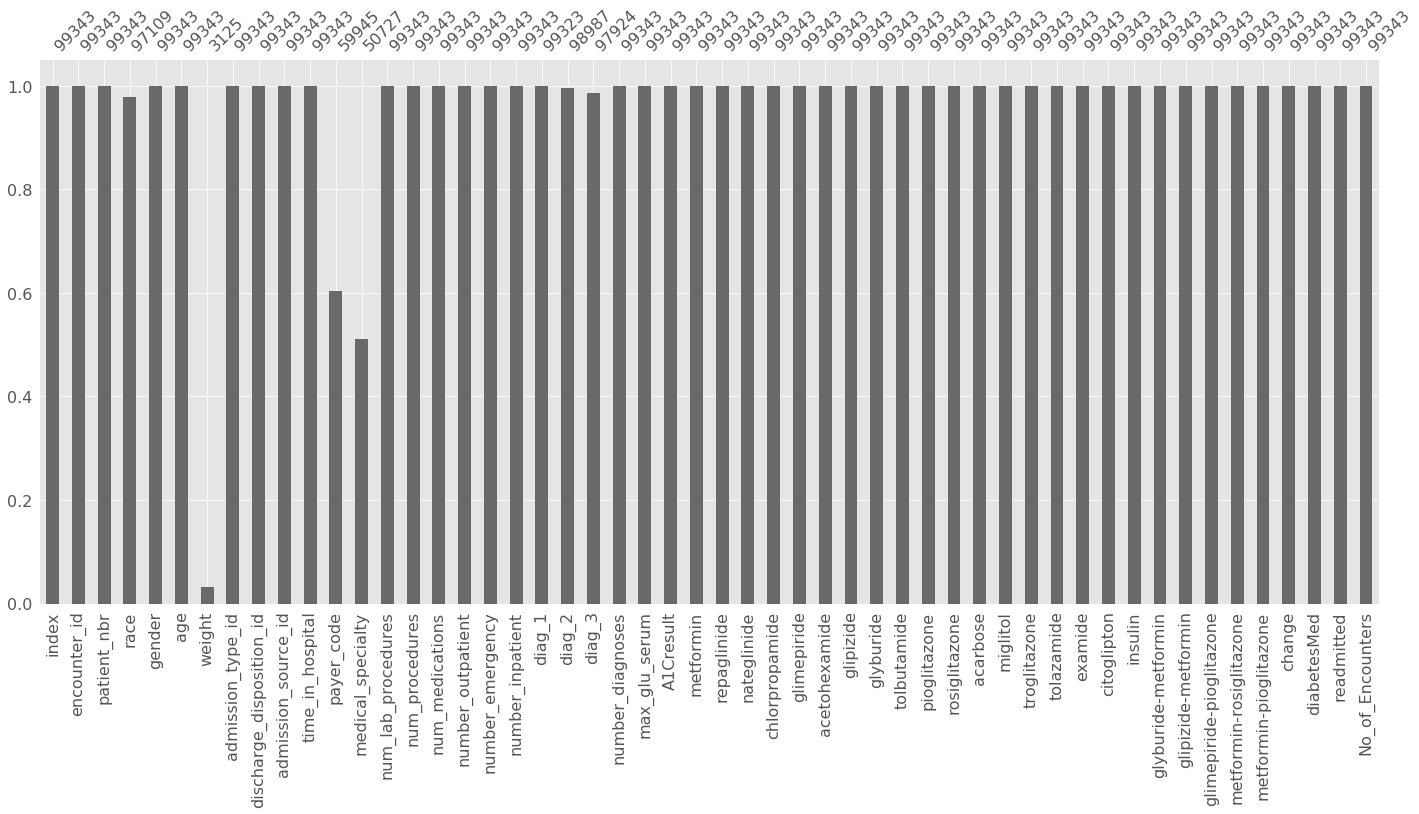

In [141]:
# PLot the missing value count on the chart below
msno.bar(dia_df1)

In [142]:
#Dropping the columnns["Weight,payer_code and medical_specialty"] as they have a lot of missing values [> 1/3rd of the data]
dia_df1 = dia_df1.drop('weight', axis=1)
dia_df1 = dia_df1.drop('payer_code', axis=1)
dia_df1 = dia_df1.drop('medical_specialty', axis=1)

#Replace  ~3% of data points for race with Unknown
dia_df1['race'].replace('?', 'Unknown')

#Delete observations where diag_1, diag_2, diag_3 values are missing in all three & replaced the remaining with 'Unknown'
dia_df1.drop(dia_df1[(dia_df1['diag_1'] == '?') & (dia_df1['diag_2'] == '?')
               & (dia_df1['diag_3'] == '?')].index, inplace=True)

In [143]:
#Summarizing categorical variables to understand drugs data

def unique_values_categorical_features(dataframe):
    assert isinstance(dataframe, pd.DataFrame)
    df = dataframe.select_dtypes(include=object)
    unique_dict = {}
    for col in df.columns.tolist():
        assert isinstance(dataframe[col], object)
        unique_dict[col] = df[col].unique()
    return unique_dict

def value_counts_categorical_features(dataframe):
    assert isinstance(dataframe, pd.DataFrame)
    df = dataframe.select_dtypes(include=object)
    value_counts_dict = {}
    for col in df.columns.tolist():
        assert isinstance(dataframe[col], object)
        value_counts_dict[col] = df[col].value_counts()
    return value_counts_dict

In [144]:
print(value_counts_categorical_features(categorical_features_df))

{'race': Caucasian          52292
AfricanAmerican    12625
Hispanic            1500
Other               1150
Asian                488
Name: race, dtype: int64, 'gender': Female             37229
Male               32741
Unknown/Invalid        3
Name: gender, dtype: int64, 'age': [70-80)     17750
[60-70)     15684
[50-60)     12349
[80-90)     11102
[40-50)      6828
[30-40)      2692
[90-100)     1760
[20-30)      1121
[10-20)       534
[0-10)        153
Name: age, dtype: int64, 'diag_1': 414      5209
428      3876
786      3040
410      2774
486      2362
427      2019
715      1907
434      1514
682      1463
780      1409
491      1313
276      1180
996      1106
250.8    1074
38        998
599       975
584       918
820       815
574       773
435       752
562       709
577       682
493       676
722       660
V57       654
296       634
250.6     631
433       608
440       607
518       562
         ... 
314         1
365         1
842         1
471         1
690         1
3

Few of the Drugs Columns as stated below have been removed.
These have either only one value or more than one unique values but one of the values has insignificant frequency in the dataset

For example, out of the total of 69973 observations :
Tolazamide has only 1 value
Examide has only 1 value
Citoglipton has only 1 value
Rosiglitazone has only 1 value
Glipizide-Metformin has only 1 value
Glimepiride - 2 values split in the ratio : (69772 : 1)
Metformin-Rosiglitazone - 2 values split in the ratio : (69772 : 1)
Glimepiride-Pioglitazone - 2 values split in the ratio : (69771 : 2)
Troglitazone - 2 values split in the ratio : (69770 : 3)
We drop these drugs columns next

In [145]:
dia_df1.drop(['tolazamide', 'examide', 'citoglipton', 'rosiglitazone', 'glipizide-metformin', 'glimepiride', 
              'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'troglitazone'], axis=1, inplace=True)

In [146]:
#Removing columns which are redundant
#We already see a lot of columns already which show about the diabetes medications
dia_df1.drop('diabetesMed', axis=1, inplace=True)

What have we done so far in Data Preparation stage , summarized below :
a) Remove 29 features in total: 
   7 features as below related to numeric data: 
  'encounter_id', 'patient_nbr', 'payer_code', 'weight', 'medical_specialty', 'diag_2', 'diag_3', and 
   22 features for data related to medications :
'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', and 'metformin-pioglitazone'
b) Remove NA in 'race', 'gender', 'diag_1', 'diag_2', and 'diag_3'
c) Age column is an object datatype because we were provided with information as 10 year bins
d) Recategorize 'age' feature
e) Reduce levels in 'discharge_disposition_id', 'admission_source_id', and 'admission_type_id'
f) One-hot-encode on categorical data
g) Square root transform on right skewed count data
h) Apply feature standardizing on numerical data

# Numerical Variables

In [147]:
# Subset the numerical columns
numerical_features_df = subset_dia_df(dia_df1, 'number')
numerical_features_df.columns.tolist()

['index',
 'encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'No_of_Encounters']

# EDA on the numerical Data

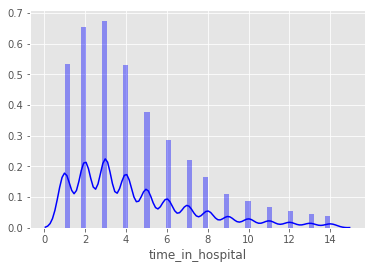

In [148]:
sns.distplot(numerical_features_df['time_in_hospital'], color="blue")

Text(0,0.5,'Count')

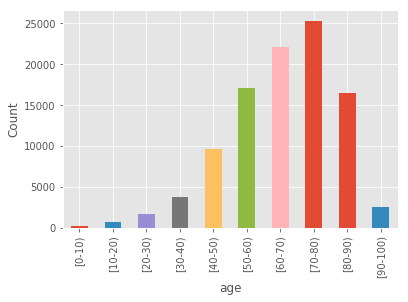

In [166]:
# check 'age' feature
dia_df1.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

Text(0,0.5,'Count')

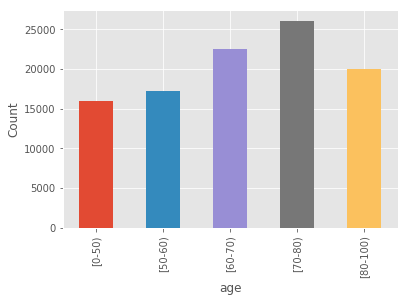

In [167]:
# Recategorize 'age' so that the population is more evenly distributed
dia_df['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                         for val in dia_df['age']], index=dia_df.index)
dia_df['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                         for val in dia_df['age']], index=dia_df.index)

dia_df.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

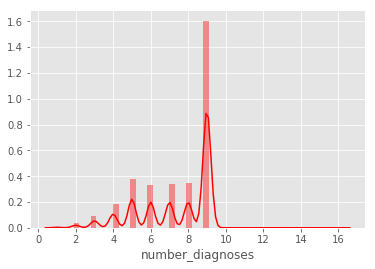

In [149]:
sns.distplot(numerical_features_df['number_diagnoses'], color="red")

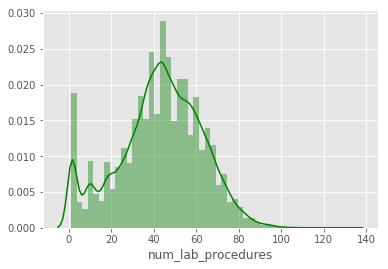

In [150]:
sns.distplot(numerical_features_df['num_lab_procedures'], color="green")

# Log Transformations

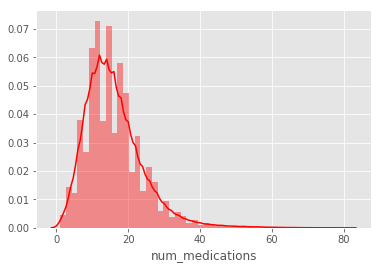

In [151]:
sns.distplot(numerical_features_df['num_medications'], color="red")

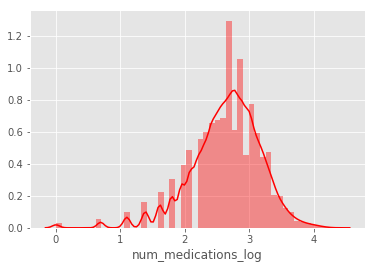

In [152]:
dia_df1['num_medications_log'] = np.log(dia_df1['num_medications'])
sns.distplot(dia_df1['num_medications_log'], color="red")

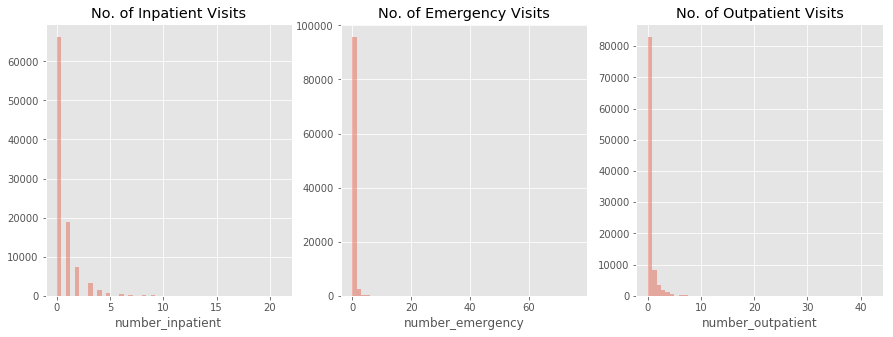

In [153]:
# Understanding the distribution of no of visits [ Inpatients, Outpatients and Emergency]
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)


ax[0].set_title("No. of Inpatient Visits",  y=y_title_margin)
ax[1].set_title("No. of Emergency Visits",   y=y_title_margin)
ax[2].set_title("No. of Outpatient Visits",   y=y_title_margin)

sns.distplot(dia_df1["number_inpatient"], kde=False, ax=ax[0])
sns.distplot(dia_df1["number_emergency"],  kde=False, ax=ax[1])
sns.distplot(dia_df1["number_outpatient"],  kde=False, ax=ax[2])

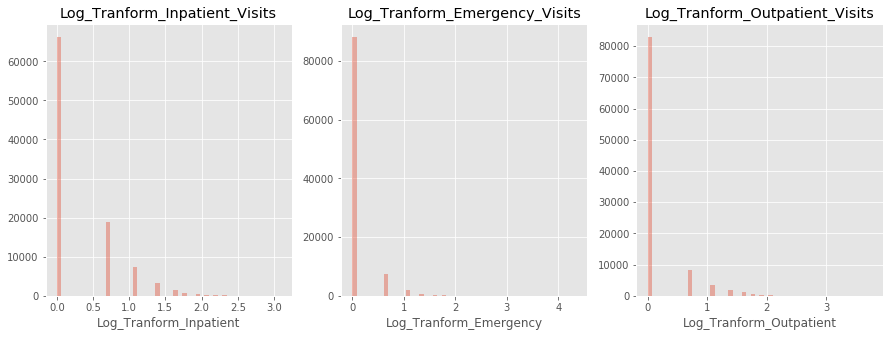

In [154]:
dia_df1['Log_Tranform_Inpatient'] = np.log1p(dia_df1['number_inpatient'])
dia_df1['Log_Tranform_Emergency'] = np.log1p(dia_df1['number_emergency'])
dia_df1['Log_Tranform_Outpatient'] = np.log1p(dia_df1['number_outpatient'])
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)


ax[0].set_title("Log_Tranform_Inpatient_Visits",  y=y_title_margin)
ax[1].set_title("Log_Tranform_Emergency_Visits",   y=y_title_margin)
ax[2].set_title("Log_Tranform_Outpatient_Visits",   y=y_title_margin)

sns.distplot(dia_df1["Log_Tranform_Inpatient"], kde=False, ax=ax[0])
sns.distplot(dia_df1["Log_Tranform_Emergency"],  kde=False, ax=ax[1])
sns.distplot(dia_df1["Log_Tranform_Outpatient"],  kde=False, ax=ax[2])


# Understanding the Target Variable
There are three classes in the target variable.
Class 1: NO - patients not readmitted,
Class 2: <30 - readmitted <30 days after discharge
Class 3: >30 - readmitted >30 days after discharge
Since we are interested in predicting readmission :  we will assign 1 to these observations and 0 to all other observations.

In [155]:
# Recode and Reegroup the response variable to apply logistic regression model
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged [<30 or >30]
dia_df1['readmitted'] = pd.Series([0 if val == 'NO' else 1 for val in dia_df1['readmitted']])
dia_df1.head()

,index,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,metformin-pioglitazone,change,readmitted,No_of_Encounters,num_medications_log,Log_Tranform_Inpatient,Log_Tranform_Emergency,Log_Tranform_Outpatient
0,0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,...,No,No,No,No,0,1,0.000000,0.000000,0.0,0.000000
1,1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,...,Up,No,No,Ch,1,1,2.890372,0.000000,0.0,0.000000
2,2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,...,No,No,No,No,0,1,2.564949,0.693147,0.0,1.098612
3,3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,...,Up,No,No,Ch,0,1,2.772589,0.000000,0.0,0.000000
4,4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,...,Steady,No,No,Ch,0,1,2.079442,0.000000,0.0,0.000000


In [156]:
dia_df1['readmitted'].value_counts()

0    52527
1    46816
Name: readmitted, dtype: int64

# Data Modeling

In [158]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
import pickle

from sklearn.preprocessing import StandardScaler

In [160]:
dia_df2 = shuffle(dia_df1)
# Define X, y
y = dia_df2['readmitted']
print(y.shape)
X = dia_df2.drop('readmitted', axis=1)
print(X.shape)

(99343,)
(99343, 42)


In [161]:
#We see the prevalance is 47% , meaning 47 % of the observations belong to the class we are interested in.
def class_prevalence(label):
    return (sum(label)/len(label))
print(class_prevalence(y))

0.4712561529247154


# Splitting the data to Train/Test/Validate

In [168]:
Y = dia_df1['readmitted']
X = dia_df1.drop(['readmitted'], axis =1)
X = pd.get_dummies(X)

In [171]:
#Splitting the data into training and vallidation data sets. 
#The training data will contain 80 % of the data and validation will contain remaining 20%
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = .2, 
                                                random_state = 7, stratify = Y)
print("shape of Xtrain,Xtest:",Xtrain.shape,Xtest.shape)

shape of Xtrain,Xtest: (79474, 2345) (19869, 2345)


In [172]:
# create model logistic as logistic regression using Sklearn 
from sklearn.linear_model import LogisticRegression
logisticreg = LogisticRegression(tol=1e-7, penalty='l2', C=0.0005)
logisticreg.fit(Xtrain, Ytrain)
Ylog = logisticreg.predict(Xtest)

In [173]:
# Checking the accuracy of the model 
print(" The accuracy of the Logistic regression model:" ,logisticreg.score(Xtest, Ytest))

 The accuracy of the Logistic regression model: 0.5683728421158589


In [174]:
# checking the confusion matrix
print(confusion_matrix(Ytest, Ylog))

[[7395 3111]
 [5465 3898]]


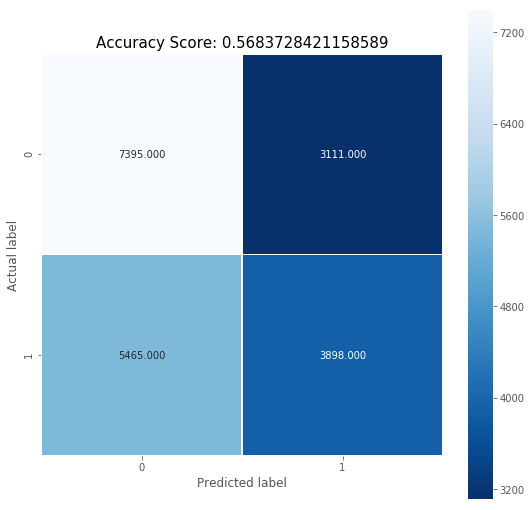

In [175]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(Ytest, Ylog), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logisticreg.score(Xtest, Ytest))
plt.title(all_sample_title, size = 15);

In [176]:

# Checking the summary of classification
from sklearn.metrics import classification_report
print(classification_report(Ytest, Ylog, target_names = ['NO', 'YES']))

             precision    recall  f1-score   support

         NO       0.58      0.70      0.63     10506
        YES       0.56      0.42      0.48      9363

avg / total       0.57      0.57      0.56     19869



In [177]:
# Checking the performance of model using ROC curve plots
YScre = logisticreg.decision_function(Xtest)

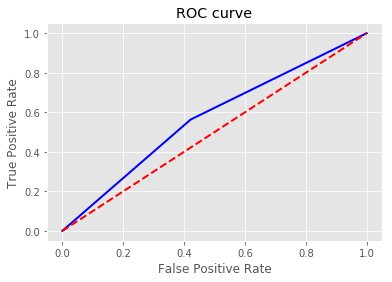

In [178]:
##Computing false and true positive rates
from sklearn.metrics import roc_curve

fpr, tpr,_=roc_curve(logisticreg.predict(Xtrain),Ytrain,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Creating the ROC,
plt.plot(fpr, tpr, color='blue',
 lw=2, label='ROC curve')
##Finding FPR and TPR,
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
##Splecifying the label and title,
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()